In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.patches import *
import numpy as np
from pylab import *
from numpy import ma
from IPython import display
%matplotlib inline

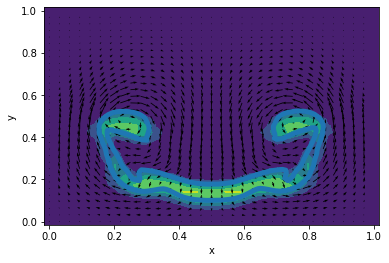

Step 99


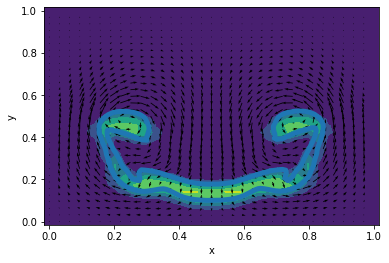

In [2]:
#===============SETUP THE COMPUTATIONAL DOMAIN==================#

#Domain size and constant parameters
Lx=1.0; Ly=1.0
gx=0.0; gy=-100.0;
rho1=1.0; rho2=2.0
m0=0.01;
mu = 0.01
rro=rho1;


#Velocity at wall boundary
unorth=0; usouth=0; veast=0; vwest=0; 

#Initial drop size and location
time=0.0; rad=0.15; xc=0.5; yc=0.7;

#Numerical variables
nx=32; ny=32;
dt=0.0025; nstep=100
maxiter=200; maxError=0.001
maxit=200
beta=1.2;   
#Set the grid
dx=Lx/nx; dy=Ly/ny
x=np.linspace(-dx/2,(nx+0.5)*dx,nx+2)
y=np.linspace(-dy/2,(ny+0.5)*dy,ny+2)

#Set density in domain and drop:
r=np.ones((nx+2,ny+2))*rho1
for i in range(1,nx+1):
    for j in range (1,ny+1):
        if ((x[i]-xc)**2+(y[j]-yc)**2)<rad**2:
            r[i,j]=rho2;
            
#Zero arrays
u=np.zeros((nx+1,ny+2)); v=np.zeros((nx+2,ny+1)); p=np.zeros((nx+2,ny+2))
ut=np.zeros((nx+1,ny+2)); vt=np.zeros((nx+2,ny+1)); tmp1=np.zeros((nx+2,ny+2));
uu=np.zeros((nx+1,ny+1)); vv=np.zeros((nx+1,ny+1)); tmp2=np.zeros((nx+2,ny+2));
Ax = np.zeros_like(u)
Dx = np.zeros_like(u)
Ay = np.zeros_like(v)
Dy = np.zeros_like(v)



#================SETUP THE FRONT=====================#
Nf=100;
xf=np.zeros((Nf+2)); yf=np.zeros((Nf+2))
for i in range(Nf+1):
    xf[i]=xc-rad*sin(2.0*np.pi*i/Nf);
    yf[i]=yc+rad*cos(2.0*np.pi*i/Nf);
    
#===============START THE TIME LOOP==================#

for step in range (nstep):
    fx=np.zeros((nx+2,ny+2)); fy=np.zeros((nx+2,ny+2))
    # Tangential velocities at boundaries
    u[:,0] = 2*usouth - u[:,1]
    u[:,-1] = 2*unorth - u[:,-2]
    v[0,:] = 2*vwest - v[1,:]
    v[-1,:] = 2*veast - v[-2,:]

    # Temporary x-velocity
    for i in range(1,nx):
        for j in range(1,ny+1):
            # Advection matrix
            Ax[i,j] = (0.25/dx*((u[i+1,j]+u[i,j])**2 - (u[i,j]+u[i-1,j])**2) + 
                      0.25/dy*((u[i,j+1]+u[i,j])*(v[i+1,j]+v[i,j]) - 
                            (u[i,j]+u[i,j-1])*(v[i+1,j-1]+v[i,j-1])))
            # Diffusion matrix
            Dx[i,j] = mu * ((u[i+1,j]-2*u[i,j]+u[i-1,j])/dx**2 + (u[i,j+1]-2*u[i,j]+u[i,j-1])/dy**2)
            # Temporary velocity
            ut[i,j] = u[i,j] + dt*(-Ax[i,j] + gx + 2*Dx[i,j]/(r[i+1,j]+r[i,j]))

    # Temporary y-velocity 
    for i in range(1,nx+1):
        for j in range(1,ny):
            # Advection matrix
            Ay[i,j] = (0.25/dx*((u[i,j]+u[i,j+1])*(v[i,j]+v[i+1,j]) -
                      (u[i-1,j+1]+u[i-1,j])*(v[i,j]+v[i-1,j])) +
                      0.25/dy*((v[i,j+1]+v[i,j])**2 - (v[i,j]+v[i,j-1])**2))
            # Diffusion matrix
            Dy[i,j] = mu * ((v[i+1,j]-2*v[i,j]+v[i-1,j])/dx**2 + (v[i,j+1]-2*v[i,j]+v[i,j-1])/dy**2)
            # Temporary velocity
            vt[i,j] = v[i,j] + dt*(-Ay[i,j] + gy + 2*Dy[i,j]/(r[i,j+1]+r[i,j]))

    # Source term for pressure equation
    rt = np.copy(r)
    lrg = 1000.
    rt[0,:] = lrg
    rt[-1,:] = lrg
    rt[:,0] = lrg
    rt[:,-1] = lrg

    # Assemble and compute pressure
    for i in range(1,nx+1):
        for j in range(1,ny+1):
            tmp1[i,j] = 1/(2*dt)*((ut[i,j]-ut[i-1,j])/dx + (vt[i,j]-vt[i,j-1])/dy)
            tmp2[i,j] = 1/((1/dx**2)*(1/(rt[i+1,j]+rt[i,j]) + 1/(rt[i,j]+rt[i-1,j])) + 
                              (1/dy**2)*(1/(rt[i,j+1]+rt[i,j]) + 1/(rt[i,j]+rt[i,j-1])))
    it = 0
    while True:
        pn = np.copy(p)
        it += 1
        for i in range(1,nx+1):
            for j in range(1,ny+1):
                p[i,j] = (1-beta)*p[i,j] + beta*tmp2[i,j]*((1/dx**2*(p[i+1,j]/(rt[i+1,j]+rt[i,j])+p[i-1,j]/(rt[i,j]+rt[i-1,j])) +
                                                      1/dy**2*(p[i,j+1]/(rt[i,j+1]+rt[i,j])+p[i,j-1]/(rt[i,j]+rt[i,j-1])) - tmp1[i,j]))
        if it%100 == 0:
            print(f'Pressure loop iterations: {it}')
        if np.abs(pn-p).max() < maxError:
            print(f'Pressure convergence achieved in {it} iterations.')
            break
        if it > maxit:
            print(f'Pressure convergence not achieved. Max iterations reached in pressure loop.')
            break

    # Update velocities
    for i in range(1,nx):
        for j in range(1,ny+1):
            u[i,j] = ut[i,j] - 2*dt/dx*(p[i+1,j]-p[i,j])/(r[i+1,j]+r[i,j])
    for i in range(1,nx+1):
        for j in range(1,ny):
            v[i,j] = vt[i,j] - 2*dt/dy*(p[i,j+1]-p[i,j])/(r[i,j+1]+r[i,j])
            
    #===============FRONT TRACKING AND DENSITY DISTRIBUTION==================#
    # Advect front (mine, validated)
    uf=np.zeros((Nf+2)); vf=np.zeros((Nf+2))
    for i in range(1, Nf+1):
        ip = int(np.floor(xf[i]/dx))
        jp = int(np.floor((yf[i]+0.5*dy)/dy))
        ax = xf[i]/dx-ip
        ay = (yf[i]+0.5*dy)/dy-jp
        uf[i] = (1-ax)*(1-ay)*u[ip,jp] + ax*(1-ay)*u[ip+1,jp] + (1-ax)*ay*u[ip,jp+1] + ax*ay*u[ip+1,jp+1]

        ip = int(np.floor((xf[i]+0.5*dx)/dx))
        jp = int(np.floor(yf[i]/dy))
        ax = (xf[i]+0.5*dx)/dx-ip
        ay = (yf[i]/dy)-jp
        vf[i] = (1-ax)*(1-ay)*v[ip,jp] + ax*(1-ay)*v[ip+1,jp] + (1-ax)*ay*v[ip,jp+1] + ax*ay*v[ip+1,jp+1]
        
    for i in range(1, Nf+1):
        xf[i] = xf[i] + dt*uf[i]
        yf[i] = yf[i] + dt*vf[i]

    xf[0] = xf[-2]
    yf[0] = yf[-2]
    xf[-1] = xf[1]
    yf[-1] = yf[1]

    # Add points to the front (mine, validated)
    xfold = np.copy(xf)
    yfold = np.copy(yf)
    xf1 = []
    yf1 = []
    xf1.append(xf[0])
    yf1.append(yf[0])
    j = 0
    for i in range(1, Nf+1):
        ds = np.sqrt(((xfold[i]-xf1[j])/dx)**2 + ((yfold[i] - yf1[j])/dy)**2)
        if ds > 0.5:
            j += 1
            xf1.append(0.5*(xfold[i]+xf1[j-1]))
            yf1.append(0.5*(yfold[i]+yf1[j-1]))
            j += 1
            xf1.append(xfold[i])
            yf1.append(yfold[i])
        elif ds > 0.25:
            j += 1
            xf1.append(xfold[i])
            yf1.append(yfold[i])
    Nf = j-1
    xf = np.asarray(xf1)
    yf = np.asarray(yf1)
    xf[0] = xf[-2]
    yf[0] = yf[-2]
    xf[-1] = xf[1]
    yf[-1] = yf[1]
    
    # Distribute gradient (mine, validated)
    fx = np.zeros((nx+2,ny+2))
    fy = np.zeros((nx+2, ny+2))
    for i in range(1, Nf+1):
        nfx = -0.5*(yf[i+1]-yf[i-1])*(rho2-rho1)
        nfy = 0.5*(xf[i+1]-xf[i-1])*(rho2-rho1)

        ip=int(np.floor(xf[i]/dx)) 
        jp=int(np.floor((yf[i]+0.5*dy)/dy))
        ax=xf[i]/dx-ip
        ay=(yf[i]+0.5*dy)/dy-jp;
        fx[ip,jp] = fx[ip,jp]+(1-ax)*(1-ay)*nfx/(dx*dy)
        fx[ip+1,jp] = fx[ip+1,jp]+ax*(1-ay)*nfx/(dx*dy)
        fx[ip,jp+1] = fx[ip,jp+1]+ay*(1-ax)*nfx/(dx*dy) 
        fx[ip+1,jp+1]=fx[ip+1,jp+1]+ax*ay*nfx/(dx*dy)

        ip=int(np.floor((xf[i]+0.5*dx)/dx))
        jp=int(np.floor(yf[i]/dy))
        ax=(xf[i]+0.5*dx)/dx-ip
        ay=yf[i]/dy-jp
        fy[ip,jp]=fy[ip,jp]+(1-ax)*(1-ay)*nfy/(dx*dy)
        fy[ip+1,jp]=fy[ip+1,jp]+ax*(1-ay)*nfy/(dx*dy)
        fy[ip,jp+1]=fy[ip,jp+1]+(1-ax)*ay*nfy/(dx*dy)
        fy[ip+1,jp+1]=fy[ip+1,jp+1]+ax*ay*nfy/(dx*dy)


    #Construct the density
    iter=0
    while True:
        rt=r.copy()
        iter=iter+1
        r[1:-1,1:-1]=0.25*(r[2:,1:-1]+r[0:-2,1:-1]+r[1:-1,2:]+r[1:-1,0:-2]+
                          dx*(fx[0:-2,1:-1]-fx[1:-1,1:-1])+ dy*(fy[1:-1,0:-2]-fy[1:-1,2:]))
        if np.abs(rt-r).max()<maxError:
            break
        if iter>maxiter:
            break
            # Plot the density contour and the velocity field
    uu = 0.5*(u[0:nx,1:ny+1] + u[0:nx,0:ny])
    vv = 0.5*(v[1:nx+1,0:ny] + v[0:nx,0:ny])
    yy, xx = np.mgrid[0:(nx-1)*dx:nx*1j, 0:(ny-1)*dy:ny*1j]
    X, Y = np.meshgrid(x, y)
    plt.clf()
    plt.contourf(x,y,r.T,5)
    plt.quiver(xx,yy,uu.T,vv.T)
    plt.plot(xf[0:Nf+1], yf[0:Nf+1],linewidth=5.0)
    plt.xlabel('x')
    plt.ylabel('y')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    print(f'Step {step}')